# 프로젝트 : 다음에 볼 영화 추천하기

In [1]:
import os
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## STEP 1. 데이터 전처리

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [6]:
session_length.min(), session_length.max()

(20, 2314)

In [7]:
session_length.quantile(0.99)

906.659999999998

In [8]:
session_length.sort_values().tail(20)

UserId
3841    1216
5831    1220
4227    1222
424     1226
4510    1240
1449    1243
2909    1258
1980    1260
4344    1271
5795    1277
1015    1286
1150    1302
2063    1323
3618    1344
889     1518
1181    1521
1941    1595
4277    1743
1680    1850
4169    2314
dtype: int64

In [9]:
long_session = session_length[session_length==session_length.min()].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
12780,98,3244,3,2000-12-24 00:47:34
12791,98,1210,3,2000-12-24 00:47:34
12792,98,2028,5,2000-12-24 00:48:27
12776,98,2302,3,2000-12-24 00:49:10
12778,98,920,5,2000-12-24 00:54:08
12779,98,1562,3,2000-12-24 00:54:08
12774,98,1250,5,2000-12-24 00:55:49
12788,98,1997,2,2000-12-24 00:55:49
12781,98,3507,4,2000-12-24 00:56:16
12784,98,3578,5,2000-12-24 00:56:16


* 최소 길이가 20이므로 충분히 다음 클릭을 예측이 가능합니다. 따라서 제외하지 않습니다.

In [10]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


* 혼자 같은 시간에 여러번 평점을 올린것으로 보아 악의적인 어뷰징으로 보입니다.  
전처리때 필히 삭제합시다.

In [11]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum <= 0.91]

length_percent_cumsum_999

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
414    0.908775
415    0.908940
416    0.909272
417    0.909437
419    0.909768
Length: 395, dtype: float64

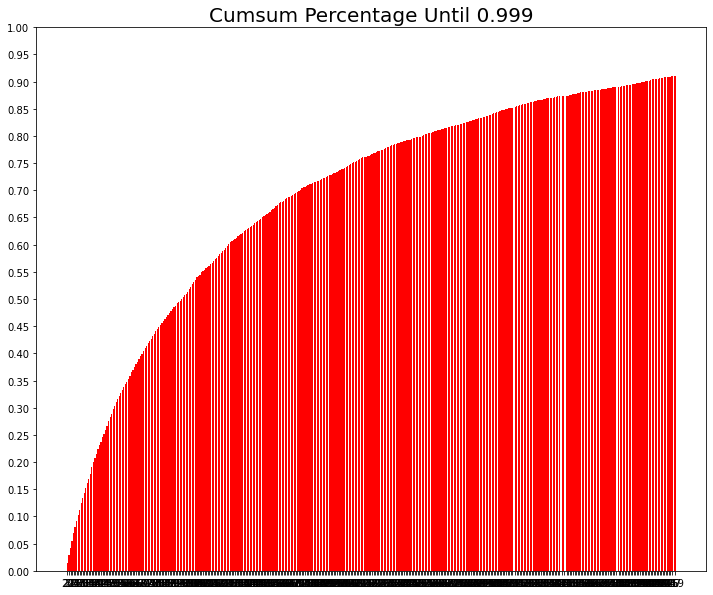

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

* 누적 분포가 거의 균일하게 올라가기때문에 91퍼센트까지 사용하면 될거같습니다.

In [13]:
# 99퍼센트 까지는 최대 906번의 클릭 데이터가 있음 클릭 수 이하의 유저를 모두 모음
allow = [v for v in session_length.index if session_length[v] <= 906]
len(allow)

5979

In [14]:
#조건에 맞는 유저만 추린다
data = data[data['UserId'].isin(allow)]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


* 클릭 수 420번 이하의 유저 정보만 가져왔습니다.

In [15]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


* 약 3년간의 데이터입니다.

In [16]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [17]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


* 영화를 적게 본 유저와 적게 시청된 영화를 삭제합니다.

In [18]:
#약 몇개월간의 데이터를 사용할것인지 인자로 받으면 해당 시간의 경계를 반환
def time_bound(latest,num):
    c = 2628000*num
    return latest-dt.timedelta(c)

In [19]:
# #1년간의 데이터를 사용합니다
# years_ago = time_bound(latest,12)
# data = data[data['Time'] > years_ago]
# data

In [20]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date

In [21]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [22]:
data = data.sort_values(by=['Time'])

In [23]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [24]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 911204
	 Sessions: 5977
	 Items: 3386
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 10633
	 Sessions: 376
	 Items: 2436
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 7906
	 Sessions: 318
	 Items: 2165
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [25]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [26]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## STEP 2. 미니 배치의 구성

In [27]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [28]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.tail()

,UserId,ItemId,Rating,Time,item_idx
1000019,6040,2917,4,2001-08-10 14:40:29,1248
999988,6040,1921,4,2001-08-10 14:41:04,370
1000172,6040,1784,3,2001-08-10 14:41:04,89
1000167,6040,161,3,2001-08-10 14:41:26,464
1000042,6040,1221,4,2001-08-20 13:44:15,430


In [29]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 910740, 910863, 911204], dtype=int32)

In [30]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5974, 5975, 5976])

In [31]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [32]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [33]:
iter_ex = iter(tr_data_loader)

In [34]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## STEP 3. 모델 구성

In [35]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [36]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [37]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

## STEP 4. 모델 학습

In [38]:
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

## STEP 5. 모델 테스트
* 하이퍼 파리미터를 바꿔가며 가장 학습이 잘되는 모델을 찾아보겠습니다.

In [39]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

#### 모델 1 테스트

In [40]:
args1 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model1 = create_model(args1)
train_model(model1, args1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3386)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    515700    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3386)               172686    
Total params: 688,386
Trainable params: 688,386
Non-trainable params: 0
_________________________________________________________________


Evaluation:  12%|█▎        | 5/40 [00:07<00:49,  1.41s/it]


	 - Recall@20 epoch 1: 0.061719
	 - MRR@20    epoch 1: 0.015470



Evaluation:  12%|█▎        | 5/40 [00:06<00:46,  1.34s/it]


	 - Recall@20 epoch 2: 0.091406
	 - MRR@20    epoch 2: 0.026361



Evaluation:  12%|█▎        | 5/40 [00:06<00:46,  1.32s/it]


	 - Recall@20 epoch 3: 0.105469
	 - MRR@20    epoch 3: 0.031793



Evaluation:  12%|█▎        | 5/40 [00:06<00:45,  1.30s/it]


	 - Recall@20 epoch 4: 0.112500
	 - MRR@20    epoch 4: 0.033063



Evaluation:  12%|█▎        | 5/40 [00:06<00:45,  1.31s/it]

	 - Recall@20 epoch 5: 0.116406
	 - MRR@20    epoch 5: 0.034916



#### 모델 2 테스트

In [41]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3386)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    515700    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3386)               172686    
Total params: 688,386
Trainable params: 688,386
Non-trainable params: 0
_________________________________________________________________


Evaluation:  44%|████▍     | 35/80 [00:23<00:30,  1.46it/s]


	 - Recall@20 epoch 1: 0.095312
	 - MRR@20    epoch 1: 0.024595



Evaluation:  44%|████▍     | 35/80 [00:23<00:30,  1.49it/s]


	 - Recall@20 epoch 2: 0.118304
	 - MRR@20    epoch 2: 0.034513



Evaluation:  44%|████▍     | 35/80 [00:23<00:30,  1.50it/s]


	 - Recall@20 epoch 3: 0.130580
	 - MRR@20    epoch 3: 0.038573



Evaluation:  44%|████▍     | 35/80 [00:23<00:30,  1.49it/s]


	 - Recall@20 epoch 4: 0.139955
	 - MRR@20    epoch 4: 0.040337



Evaluation:  44%|████▍     | 35/80 [00:23<00:30,  1.46it/s]

	 - Recall@20 epoch 5: 0.140179
	 - MRR@20    epoch 5: 0.040983



#### 모델 3 테스트

In [42]:
args3 = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model3 = create_model(args3)
train_model(model3, args3)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3386)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 100), (256, 100)]  1046400   
_________________________________________________________________
dropout_2 (Dropout)          (256, 100)                0         
_________________________________________________________________
dense_2 (Dense)              (256, 3386)               341986    
Total params: 1,388,386
Trainable params: 1,388,386
Non-trainable params: 0
_________________________________________________________________


Evaluation:  12%|█▎        | 5/40 [00:06<00:48,  1.38s/it]


	 - Recall@20 epoch 1: 0.082031
	 - MRR@20    epoch 1: 0.021602



Evaluation:  12%|█▎        | 5/40 [00:06<00:45,  1.31s/it]


	 - Recall@20 epoch 2: 0.096094
	 - MRR@20    epoch 2: 0.027906



Evaluation:  12%|█▎        | 5/40 [00:06<00:47,  1.34s/it]


	 - Recall@20 epoch 3: 0.103906
	 - MRR@20    epoch 3: 0.032972



Evaluation:  12%|█▎        | 5/40 [00:06<00:46,  1.34s/it]


	 - Recall@20 epoch 4: 0.112500
	 - MRR@20    epoch 4: 0.034068



Evaluation:  12%|█▎        | 5/40 [00:06<00:45,  1.31s/it]

	 - Recall@20 epoch 5: 0.110156
	 - MRR@20    epoch 5: 0.035190



#### 모델 4 테스트

In [43]:
args4 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.01, lr=0.001, epochs=5, k=20)
model4 = create_model(args4)
train_model(model4, args4)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(256, 1, 3386)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    515700    
_________________________________________________________________
dropout_3 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (256, 3386)               172686    
Total params: 688,386
Trainable params: 688,386
Non-trainable params: 0
_________________________________________________________________


Evaluation:  12%|█▎        | 5/40 [00:07<00:49,  1.41s/it]


	 - Recall@20 epoch 1: 0.060937
	 - MRR@20    epoch 1: 0.015427



Evaluation:  12%|█▎        | 5/40 [00:06<00:44,  1.28s/it]


	 - Recall@20 epoch 2: 0.096875
	 - MRR@20    epoch 2: 0.028416



Evaluation:  12%|█▎        | 5/40 [00:06<00:45,  1.29s/it]


	 - Recall@20 epoch 3: 0.102344
	 - MRR@20    epoch 3: 0.026957



Evaluation:  12%|█▎        | 5/40 [00:06<00:45,  1.31s/it]


	 - Recall@20 epoch 4: 0.109375
	 - MRR@20    epoch 4: 0.029881



Evaluation:  12%|█▎        | 5/40 [00:06<00:47,  1.37s/it]

	 - Recall@20 epoch 5: 0.107813
	 - MRR@20    epoch 5: 0.033508



#### 모델 5 테스트

In [44]:
args5 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.005, epochs=5, k=20)
model5 = create_model(args5)
train_model(model5, args5)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(256, 1, 3386)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    515700    
_________________________________________________________________
dropout_4 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_4 (Dense)              (256, 3386)               172686    
Total params: 688,386
Trainable params: 688,386
Non-trainable params: 0
_________________________________________________________________


Evaluation:  12%|█▎        | 5/40 [00:06<00:47,  1.35s/it]


	 - Recall@20 epoch 1: 0.107813
	 - MRR@20    epoch 1: 0.025975



Evaluation:  12%|█▎        | 5/40 [00:06<00:45,  1.30s/it]


	 - Recall@20 epoch 2: 0.123438
	 - MRR@20    epoch 2: 0.034634



Evaluation:  12%|█▎        | 5/40 [00:06<00:46,  1.34s/it]


	 - Recall@20 epoch 3: 0.113281
	 - MRR@20    epoch 3: 0.035490



Evaluation:  12%|█▎        | 5/40 [00:06<00:46,  1.32s/it]


	 - Recall@20 epoch 4: 0.118750
	 - MRR@20    epoch 4: 0.035817



Evaluation:  12%|█▎        | 5/40 [00:06<00:45,  1.30s/it]

	 - Recall@20 epoch 5: 0.115625
	 - MRR@20    epoch 5: 0.035154



### 성능 평가

#### 모델 1

In [45]:
test_model(model1,args1,test)

Evaluation:   7%|▋         | 2/29 [00:02<00:37,  1.37s/it]

	 - Recall@20: 0.125000
	 - MRR@20: 0.042146



* batch_size=256, hsz=50, drop_rate=0.1, lr=0.001의 기본 모델입니다.

#### 모델 2
* batch_size=128

In [46]:
test_model(model2,args2,test)

Evaluation:  37%|███▋      | 22/59 [00:14<00:24,  1.50it/s]

	 - Recall@20: 0.157315
	 - MRR@20: 0.048862



* batch_size = 128 입니다. 학습 시간은 오래걸리지만 recall과 MRR이 가장 크게 늘어났습니다.

#### 모델 3
* hsz=100

In [47]:
test_model(model3,args3,test)

Evaluation:   7%|▋         | 2/29 [00:02<00:35,  1.32s/it]

	 - Recall@20: 0.126953
	 - MRR@20: 0.046645



* 기본 모델에 비해 큰 변화가 없습니다.

#### 모델 4
* drop_rate=0.01

In [48]:
test_model(model4,args4,test)

Evaluation:   7%|▋         | 2/29 [00:02<00:35,  1.32s/it]

	 - Recall@20: 0.130859
	 - MRR@20: 0.037986



* Recall은 소폭 상승했지만 MRR은 많이 감소했습니다.

#### 모델 5
* lr=0.005

In [49]:
test_model(model5,args5,test)

Evaluation:   7%|▋         | 2/29 [00:02<00:34,  1.27s/it]

	 - Recall@20: 0.119141
	 - MRR@20: 0.039844



* Recall과 MRR이 모두 감소했습니다.

# 회고합시다.
* 모든 모델이 정확도가 그렇게 높지는 않지만 관심상품을 정확히 추천하는 것보다 어느정도 연관성이 있는 다른 카테고리의 제품을 추천하며 유저의 관심 폭을 늘려가는 것도 괜찮은 전략이라고 생각합니다.